In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(69420)

# Implementation : Baseline

Since we need a comparison, we will first see how would a fully connected NN trained with normal backprop perform.

In [3]:
def glorot_init(shape):
    fan_out,fan_in = shape
    limit = np.sqrt(6/(fan_in+fan_out))
    params = np.random.uniform(low=limit*-1,high=limit,size=shape)
    return params

In [4]:
def relu(a,prime=False):
    if not prime:
        mask = a > 0
        return a * mask
    else:
        mask = a > 0
        return mask.astype(np.float32)

In [5]:
def softmax(a,prime=False):
    a = np.exp(a)
    a = a / np.sum(a,axis=0)
    return a

In [6]:
def targets_to_onehot(targets,numclass):
    onehot = np.zeros((numclass,len(targets)))
    onehot[targets,np.arange(len(targets))] = 1
    return onehot

In [7]:
def crossentropy_with_logits(logits_out, y,prime=False):
    num_classes, num_samples = logits_out.shape
    y_onehot = targets_to_onehot(y,num_classes)
    assert logits_out.shape == y_onehot.shape
    softmaxed = softmax(logits_out)
    if prime:
        softmaxed[y,np.arange(num_samples)] -=1
        return softmaxed
    else:
        return np.sum(np.nan_to_num(y_onehot * np.log(softmaxed) + (1-y_onehot) * np.log((1-softmaxed))))

In [8]:
def SGDOptimizer(gradients,parameters,learningrate):
    parameters = [p - learningrate * g for p,g in zip(parameters,gradients)]
    return parameters

In [9]:
class FCNN(object):
    
    def __init__(self, layers_size,initializer_weight,initializer_bias,activation,loss_function,optimizer):
        self.layers_size = layers_size
        self.weights = [initializer_weight((k,j)) for j,k in zip(layers_size[:-1],layers_size[1:])]
        self.biases = [initializer_bias((k,1)) for k in layers_size[1:]]
        self.activation = activation
        self.loss_function = loss_function
        self.optimizer = optimizer
    
    def feedforward(self,X):
        a = X
        zs = []
        acs = [a]
        for w,b in zip(self.weights,self.biases):
            a = np.dot(w,a) + b
#             print(a.shape)
            zs.append(a)
            a = self.activation(a)
            acs.append(a)
        return a, zs, acs
    
    def feedforward_softmax(self,X):
        final_a, _, _ = self.feedforward(X)
        final_a = np.exp(final_a)
#         print(final_a.shape)
        final_a = final_a / np.sum(final_a,axis=0)
        return final_a
    
    def backpropagation(self,X,y):
        input_dim, batch_size = X.shape
        final_activation, zs, acs = self.feedforward(X)
        delta_w = [np.zeros(w.shape) for w in self.weights]
        delta_b = [np.zeros(b.shape) for b in self.biases]
        error = self.loss_function(final_activation,y,prime=True) * self.activation(zs[-1],True)
        delta_w[-1] += np.einsum('ik,jk->ijk',error,acs[-2]).mean(axis=2)
        delta_b[-1] += np.expand_dims(error,1).mean(axis=2)
        for i in range(2,len(self.layers_size)):
            error = np.einsum('ik,ij->jk',error,self.weights[-i+1]) * self.activation(zs[-i],prime=True)
            delta_w[-i] += np.einsum('ik,jk->ijk',error,acs[-i-1]).mean(axis=2)
            delta_b[-i] += np.expand_dims(error,1).mean(axis=2) 
        return delta_w, delta_b
    
    def fit(self,X,y,batch_size,epochs,lr):
        # expecting X and y to be already numpy array with the num_samples as 
        # 1st dim
        history = np.zeros(epochs * ((X.shape[0] // batch_size ) + 1))
        history -= 1
        index = 0
        for epoch in range(epochs):
            indices = np.arange(X.shape[0],dtype=np.int32)
            np.random.shuffle(indices)
            X = X.copy()[indices,:]
            y = y.copy()[indices]
            i = 0
            batches_X = [X[k:k+batch_size] for k in range(0,X.shape[0],batch_size)]
            batches_y = [y[k:k+batch_size] for k in range(0,y.shape[0],batch_size)]
            losses = 0
            for Xb, yb in zip(batches_X,batches_y):
                delta_w, delta_b = self.backpropagation(Xb.T, yb.T)
#                 print(delta_w)
                self.weights = self.optimizer(delta_w,self.weights,lr)
                self.biases = self.optimizer(delta_b,self.biases,lr)
                logits,_,_ = self.feedforward(Xb.T)
                losses += self.loss_function(logits,yb.T) / (Xb.shape[0] * len(batches_X))
#                 print((Xb.shape[0] * len(batches_X)))
            history[index] = losses
            index += 1
            print(f"Epoch {epoch} done. Loss : {losses}")
        return history
    
    def predict(self,X):
        softmaxed = self.feedforward_softmax(X.T)
        preds = np.argmax(softmaxed,axis=0)
        return preds
    
    def score(self, X, y):
        preds = self.predict(X)
        assert preds.shape == y.shape
        return np.mean(preds == y) * 100

In [9]:
mnist_data = np.load('../Dataset/Mnist/train.npy')

In [10]:
mnist_label = mnist_data[:,0]
mnist_pixels = mnist_data[:,1:] / 255

In [11]:
smol_batch_pixels = mnist_pixels[:32,:]
smol_batch_label = mnist_label[:32].astype(np.int32)

In [13]:
nn_overfit = FCNN([784,100,100,10],glorot_init,glorot_init,relu,crossentropy_with_logits,SGDOptimizer)

In [14]:
hist = nn_overfit.fit(smol_batch_pixels,smol_batch_label,32,1000,0.001)

Epoch 0 done. Loss : -3.3588905578185164
Epoch 1 done. Loss : -3.280593753441908
Epoch 2 done. Loss : -3.3236608362958906
Epoch 3 done. Loss : -3.3152212566835733
Epoch 4 done. Loss : -3.2603411842711845
Epoch 5 done. Loss : -3.3733784236977638
Epoch 6 done. Loss : -3.3746526820809484
Epoch 7 done. Loss : -3.2866327917828566
Epoch 8 done. Loss : -3.29654689452052
Epoch 9 done. Loss : -3.237620436131283
Epoch 10 done. Loss : -3.3050834864443295
Epoch 11 done. Loss : -3.2215381349114742
Epoch 12 done. Loss : -3.2621561463746236
Epoch 13 done. Loss : -3.2384017758763504
Epoch 14 done. Loss : -3.1937901162796836
Epoch 15 done. Loss : -3.3055841373682053
Epoch 16 done. Loss : -3.2009358370508285
Epoch 17 done. Loss : -3.2460001574634556
Epoch 18 done. Loss : -3.259441963909127
Epoch 19 done. Loss : -3.269570512872907
Epoch 20 done. Loss : -3.271008446573078
Epoch 21 done. Loss : -3.233889364624738
Epoch 22 done. Loss : -3.1924522089998044
Epoch 23 done. Loss : -3.2205110821434886
Epoch 24 d

Epoch 197 done. Loss : -2.7380139045032665
Epoch 198 done. Loss : -2.67680631260286
Epoch 199 done. Loss : -2.715475438474315
Epoch 200 done. Loss : -2.671673643060009
Epoch 201 done. Loss : -2.7279343443866897
Epoch 202 done. Loss : -2.741203710844296
Epoch 203 done. Loss : -2.70826486702467
Epoch 204 done. Loss : -2.6449523246608306
Epoch 205 done. Loss : -2.7239201490796967
Epoch 206 done. Loss : -2.6862290101422226
Epoch 207 done. Loss : -2.6223961955590567
Epoch 208 done. Loss : -2.6875854331708378
Epoch 209 done. Loss : -2.59854138327963
Epoch 210 done. Loss : -2.740614211625929
Epoch 211 done. Loss : -2.520626798611643
Epoch 212 done. Loss : -2.593083715132561
Epoch 213 done. Loss : -2.6045085525739364
Epoch 214 done. Loss : -2.687128442793418
Epoch 215 done. Loss : -2.58101915638711
Epoch 216 done. Loss : -2.624529155126246
Epoch 217 done. Loss : -2.617517026168907
Epoch 218 done. Loss : -2.531980031522318
Epoch 219 done. Loss : -2.6175634183210725
Epoch 220 done. Loss : -2.575

Epoch 392 done. Loss : -1.973873547131369
Epoch 393 done. Loss : -1.9772604080633354
Epoch 394 done. Loss : -2.0850567871760646
Epoch 395 done. Loss : -2.068202555418229
Epoch 396 done. Loss : -2.0831096431163405
Epoch 397 done. Loss : -1.9008210920955644
Epoch 398 done. Loss : -2.2261029933139787
Epoch 399 done. Loss : -1.9388626886610862
Epoch 400 done. Loss : -1.7708087156034655
Epoch 401 done. Loss : -1.996998311858213
Epoch 402 done. Loss : -2.0183065200580224
Epoch 403 done. Loss : -2.0537100302674047
Epoch 404 done. Loss : -2.092002282848525
Epoch 405 done. Loss : -2.04276861204754
Epoch 406 done. Loss : -2.0481045627362766
Epoch 407 done. Loss : -1.981777887032634
Epoch 408 done. Loss : -1.9119024234537232
Epoch 409 done. Loss : -1.9473295325920779
Epoch 410 done. Loss : -1.8579820572443924
Epoch 411 done. Loss : -1.8188042536673126
Epoch 412 done. Loss : -1.8769841831747958
Epoch 413 done. Loss : -1.8982080115344968
Epoch 414 done. Loss : -1.94606054646751
Epoch 415 done. Loss

Epoch 585 done. Loss : -1.5139336687689742
Epoch 586 done. Loss : -1.4414510739659139
Epoch 587 done. Loss : -1.4288897377670846
Epoch 588 done. Loss : -1.315201400375416
Epoch 589 done. Loss : -1.3388321347340346
Epoch 590 done. Loss : -1.3617248184881507
Epoch 591 done. Loss : -1.2729182928775278
Epoch 592 done. Loss : -1.3533466838412023
Epoch 593 done. Loss : -1.3197550894473737
Epoch 594 done. Loss : -1.4002607487215624
Epoch 595 done. Loss : -1.3542096875298963
Epoch 596 done. Loss : -1.3451115680636678
Epoch 597 done. Loss : -1.5074013239341961
Epoch 598 done. Loss : -1.3351362741365644
Epoch 599 done. Loss : -1.2806491808561542
Epoch 600 done. Loss : -1.2750538937829217
Epoch 601 done. Loss : -1.2784640662002806
Epoch 602 done. Loss : -1.4514709185736492
Epoch 603 done. Loss : -1.3162302779355648
Epoch 604 done. Loss : -1.4633605312427602
Epoch 605 done. Loss : -1.5729702629344404
Epoch 606 done. Loss : -1.2979291652352887
Epoch 607 done. Loss : -1.2981026341658506
Epoch 608 do

Epoch 778 done. Loss : -0.937479698320133
Epoch 779 done. Loss : -0.9527867456992773
Epoch 780 done. Loss : -0.9996560654929608
Epoch 781 done. Loss : -0.8720764212084485
Epoch 782 done. Loss : -0.9211645332398039
Epoch 783 done. Loss : -0.9703994993350542
Epoch 784 done. Loss : -1.020309850405734
Epoch 785 done. Loss : -1.0472957453411686
Epoch 786 done. Loss : -0.9352665241965054
Epoch 787 done. Loss : -0.9401293631519015
Epoch 788 done. Loss : -0.8869306076828916
Epoch 789 done. Loss : -0.8709621208522743
Epoch 790 done. Loss : -1.001990114967603
Epoch 791 done. Loss : -0.8839928415034305
Epoch 792 done. Loss : -0.9331783805226259
Epoch 793 done. Loss : -0.90788197584596
Epoch 794 done. Loss : -1.1232599966947547
Epoch 795 done. Loss : -0.9964727689600331
Epoch 796 done. Loss : -1.0092893086659163
Epoch 797 done. Loss : -0.9362110158152033
Epoch 798 done. Loss : -1.021488029720719
Epoch 799 done. Loss : -0.8561444810882863
Epoch 800 done. Loss : -1.0043485453837764
Epoch 801 done. L

Epoch 970 done. Loss : -0.6954542448229162
Epoch 971 done. Loss : -0.7324745428115771
Epoch 972 done. Loss : -0.6040523449878723
Epoch 973 done. Loss : -0.7153311389927182
Epoch 974 done. Loss : -0.6765807457434484
Epoch 975 done. Loss : -0.6658417500706829
Epoch 976 done. Loss : -0.5698373580121995
Epoch 977 done. Loss : -0.6736993661196371
Epoch 978 done. Loss : -0.6418168290858786
Epoch 979 done. Loss : -0.6424538580882775
Epoch 980 done. Loss : -0.6550276758660453
Epoch 981 done. Loss : -0.639513484733784
Epoch 982 done. Loss : -0.6699502927336076
Epoch 983 done. Loss : -0.7316920317960168
Epoch 984 done. Loss : -0.6726660553884312
Epoch 985 done. Loss : -0.8416076673612787
Epoch 986 done. Loss : -0.7147135302594444
Epoch 987 done. Loss : -0.7926534644681622
Epoch 988 done. Loss : -0.6315854737122268
Epoch 989 done. Loss : -0.6396937179013941
Epoch 990 done. Loss : -0.7776833379230689
Epoch 991 done. Loss : -0.6696483052820987
Epoch 992 done. Loss : -0.6608104819440981
Epoch 993 do

In [15]:
samples = mnist_pixels[:120,:]
samples_y =  mnist_label[:120]

In [16]:
nn_overfit.score(smol_batch_pixels,smol_batch_label)

91.66666666666666

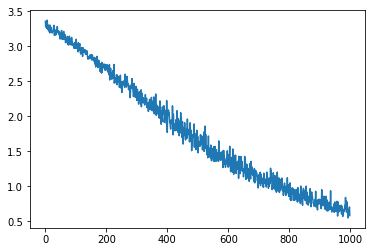

In [23]:
plt.figure()
plt.plot(-1 * hist[hist != -1])

## Now for the actual training

In [24]:
nn = FCNN([784,100,100,10],glorot_init,glorot_init,relu,crossentropy_with_logits,SGDOptimizer)

In [39]:
indices = np.arange(len(mnist_label),dtype=np.int32)
np.random.shuffle(indices)

#### Data is p big lets save 10% for test (around 420 for each classes)

In [40]:
cutoff = int(len(indices) * 0.9)

In [41]:
indices_train = indices[:cutoff]
indices_test = indices[cutoff:]

In [42]:
train_pix, train_lab = mnist_pixels[indices_train], mnist_label[indices_train].astype(np.int32)
test_pix, test_lab = mnist_pixels[indices_test], mnist_label[indices_test].astype(np.int32)

In [42]:
nn.fit(train_pix,train_lab,32,30,0.001)

Epoch 0 done. Loss : -3.166609958528909
Epoch 1 done. Loss : -2.840501271077574
Epoch 2 done. Loss : -2.441488229695912
Epoch 3 done. Loss : -2.1597728412168977
Epoch 4 done. Loss : -1.9717087369599537
Epoch 5 done. Loss : -1.6532834184361032
Epoch 6 done. Loss : -1.2553554749302782
Epoch 7 done. Loss : -1.0312653054434897
Epoch 8 done. Loss : -0.8990172782317727
Epoch 9 done. Loss : -0.8099053307366051
Epoch 10 done. Loss : -0.7468111733147337
Epoch 11 done. Loss : -0.6991609331329841
Epoch 12 done. Loss : -0.6617791247145685
Epoch 13 done. Loss : -0.6317388457863397
Epoch 14 done. Loss : -0.6078292517021041
Epoch 15 done. Loss : -0.5868746665076747
Epoch 16 done. Loss : -0.5689989377693183
Epoch 17 done. Loss : -0.5538994072735067
Epoch 18 done. Loss : -0.5406078311450844
Epoch 19 done. Loss : -0.5285316025328227
Epoch 20 done. Loss : -0.517893666568786
Epoch 21 done. Loss : -0.5079468547268643
Epoch 22 done. Loss : -0.4990189583992566
Epoch 23 done. Loss : -0.49111712228653825
Epoch

array([-3.16660996, -2.84050127, -2.44148823, ..., -1.        ,
       -1.        , -1.        ])

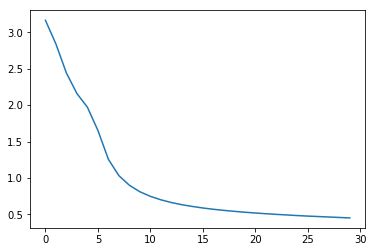

In [47]:
plt.figure()
plt.plot(x[x != -1] * -1)

## Performance of FCNN trained with normal backpropagation

In [53]:
print(f"Performance on training data : {nn.score(train_pix,train_lab)} %")

Performance on training data : 92.3994708994709 %


In [54]:
print(f"Performance on test data : {nn.score(test_pix,test_lab)} %")

Performance on test data : 92.42857142857143 %


**Not good, but eh, not our main goal.**

# Score-trained NN

Just remember to make it extra wide.

In [12]:
def kaiming_uniform(shape):
    fan_out, fan_in = shape
    params = np.random.normal(loc=0,scale=np.sqrt(2/fan_in),size=shape)
    return params

In [13]:
def MomentumSGD(lr,m):
    vl = None
    def optimizer(grads,params):
        nonlocal vl
        if vl is None:
            vl = [np.zeros(p.shape) for p in params]
        vl = [m * v + lr * g for v,g in zip(vl,grads)]
        params = [p-v for p,v in zip(params,vl)]
        return params    
    return optimizer

In [14]:
class ScoreFCNN(object):
    
    def __init__(self, layers_size,topKPercentage,initializer_weight,initializer_score,activation,loss_function,optimizer):
#         assert len(layers_size) == (len(topKPercentage)+1)
        self.layers_size = layers_size
        self.weights = [initializer_weight((k,j)) for j,k in zip(layers_size[:-1],layers_size[1:])]
        self.scores = [initializer_score(w.shape) for w in self.weights]
        self.topK = [int(j*k*topKPercentage) for j,k in zip(layers_size[:-1],layers_size[1:])]
        assert len(self.weights) == len(self.scores)
        self.activation = activation
        self.loss_function = loss_function
        self.optimizer = optimizer
    
    def feedforward(self,X):
        a = X
        zs = []
        acs = [a]
        for w,s,k in zip(self.weights,self.scores,self.topK):
            ss = s.copy()
            ww = w.copy()
            assert not np.shares_memory(ss,s)
            assert not np.shares_memory(ww,w)
#             ss = np.abs(ss)
            ss_flat = ss.ravel()
            sort_idx = ss_flat.argsort()
            ss_flat[sort_idx[-k:]] = 1
            ss_flat[sort_idx[:-k]] = 0
            assert ss.shape == w.shape
            ww = ww * ss
#             print(ww)
#             print(ww.shape)
            a = np.dot(ww,a)
            zs.append(a)
            a = self.activation(a)
            acs.append(a)
        return a, zs, acs
    
    def feedforward_softmax(self,X):
        final_a, _, _ = self.feedforward(X)
        final_a = np.exp(final_a)
        final_a = final_a / np.sum(final_a,axis=0)
        return final_a
    
    def backpropagation(self,X,y):
        input_dim, batch_size = X.shape
        final_activation, zs, acs = self.feedforward(X)
        delta_s = [np.zeros(s.shape) for s in self.scores]
        error = self.loss_function(final_activation,y,prime=True) * self.activation(zs[-1],True)
        delta_s[-1] += np.einsum('ik,jk->ijk',error,acs[-2]).mean(axis=2)
        for i in range(2,len(self.layers_size)):
            error = np.einsum('ik,ij->jk',error,self.weights[-i+1]) * self.activation(zs[-i],prime=True)
            delta_s[-i] += np.einsum('ik,jk->ijk',error,acs[-i-1]).mean(axis=2) * self.weights[-i]
        return delta_s
    
    def fit(self,X,y,batch_size,epochs):
        # expecting X and y to be already numpy array with the num_samples as 
        # 1st dim
        history = np.zeros(epochs)
        history -= 1
        index = 0
        for epoch in range(epochs):
            indices = np.arange(X.shape[0],dtype=np.int32)
            np.random.shuffle(indices)
            X = X.copy()[indices,:]
            y = y.copy()[indices]
            i = 0
            batches_X = [X[k:k+batch_size] for k in range(0,X.shape[0],batch_size)]
            batches_y = [y[k:k+batch_size] for k in range(0,y.shape[0],batch_size)]
            losses = 0
            for Xb, yb in zip(batches_X,batches_y):
                delta_s = self.backpropagation(Xb.T, yb.T)
#                 print(delta_w)
                self.scores = self.optimizer(delta_s,self.scores)
                logits,_,_ = self.feedforward(Xb.T)
                losses += self.loss_function(logits,yb.T) / (Xb.shape[0] * len(batches_X))
#                 print((Xb.shape[0] * len(batches_X)))
            history[index] = losses
            index += 1
            print(f"Epoch {epoch} done. Loss : {losses}")
        return history
    
    def predict(self,X):
        softmaxed = self.feedforward_softmax(X.T)
        preds = np.argmax(softmaxed,axis=0)
        return preds
    
    def score(self, X, y):
        preds = self.predict(X)
        assert preds.shape == y.shape
        return np.mean(preds == y) * 100

**First i overfit the model to make sure everything works**

In [32]:
optimizer = MomentumSGD(0.1,0.9)
scorenn = ScoreFCNN([784,200,200,10],0.5,kaiming_uniform,kaiming_uniform,relu,crossentropy_with_logits,optimizer)

In [33]:
hist = scorenn.fit(smol_batch_pixels,smol_batch_label,32,1000)

Epoch 0 done. Loss : -3.252302066281155
Epoch 1 done. Loss : -3.2449786571901864
Epoch 2 done. Loss : -3.243525044169675
Epoch 3 done. Loss : -3.2401745624728893
Epoch 4 done. Loss : -3.230061478858941
Epoch 5 done. Loss : -3.2167562468883286
Epoch 6 done. Loss : -3.2059987699395824
Epoch 7 done. Loss : -3.202702136771663
Epoch 8 done. Loss : -3.183546223210559
Epoch 9 done. Loss : -3.1647608707816817
Epoch 10 done. Loss : -3.1543502550415274
Epoch 11 done. Loss : -3.1353666954627037
Epoch 12 done. Loss : -3.1219117946377533
Epoch 13 done. Loss : -3.1126128121080163
Epoch 14 done. Loss : -3.103074369948213
Epoch 15 done. Loss : -3.0891996035644453
Epoch 16 done. Loss : -3.0720536424538727
Epoch 17 done. Loss : -3.0406609352287637
Epoch 18 done. Loss : -3.0256843010772254
Epoch 19 done. Loss : -2.996735482402671
Epoch 20 done. Loss : -2.9755173293493984
Epoch 21 done. Loss : -2.9623248314386244
Epoch 22 done. Loss : -2.951949010877575
Epoch 23 done. Loss : -2.9332394662551122
Epoch 24 d

Epoch 197 done. Loss : -1.2854154089772676
Epoch 198 done. Loss : -1.2764013349013847
Epoch 199 done. Loss : -1.2734751175682004
Epoch 200 done. Loss : -1.268347651207439
Epoch 201 done. Loss : -1.2656964193900357
Epoch 202 done. Loss : -1.2603971756301218
Epoch 203 done. Loss : -1.2544873467391047
Epoch 204 done. Loss : -1.253992337416428
Epoch 205 done. Loss : -1.249648261330662
Epoch 206 done. Loss : -1.242258533758882
Epoch 207 done. Loss : -1.2356855879683377
Epoch 208 done. Loss : -1.2336777506737828
Epoch 209 done. Loss : -1.228048408967438
Epoch 210 done. Loss : -1.2258502857791305
Epoch 211 done. Loss : -1.2200035652171597
Epoch 212 done. Loss : -1.2143834788827417
Epoch 213 done. Loss : -1.2178872035068433
Epoch 214 done. Loss : -1.2153024332701876
Epoch 215 done. Loss : -1.2094133975857222
Epoch 216 done. Loss : -1.2083848570049245
Epoch 217 done. Loss : -1.2058482069116012
Epoch 218 done. Loss : -1.2047906313651406
Epoch 219 done. Loss : -1.2006766253992938
Epoch 220 done. 

Epoch 390 done. Loss : -0.9891960177629199
Epoch 391 done. Loss : -0.9927292555495988
Epoch 392 done. Loss : -0.9915173808313826
Epoch 393 done. Loss : -0.9920769135993621
Epoch 394 done. Loss : -0.9892175120012205
Epoch 395 done. Loss : -0.9862303347424913
Epoch 396 done. Loss : -0.9890482018935176
Epoch 397 done. Loss : -0.9916744356696519
Epoch 398 done. Loss : -0.9933650993784676
Epoch 399 done. Loss : -0.9917495284535196
Epoch 400 done. Loss : -0.9913744538500251
Epoch 401 done. Loss : -0.9929823878874103
Epoch 402 done. Loss : -0.9917172818092461
Epoch 403 done. Loss : -0.9978468094089439
Epoch 404 done. Loss : -0.9947067560149953
Epoch 405 done. Loss : -0.9932052112465273
Epoch 406 done. Loss : -0.9925669302808535
Epoch 407 done. Loss : -0.9947852030980584
Epoch 408 done. Loss : -0.9999666450084728
Epoch 409 done. Loss : -0.9956829254004633
Epoch 410 done. Loss : -0.9946561703561436
Epoch 411 done. Loss : -0.9898551971799833
Epoch 412 done. Loss : -1.0017038450947253
Epoch 413 d

Epoch 584 done. Loss : -0.9268624518474697
Epoch 585 done. Loss : -0.9264777575087457
Epoch 586 done. Loss : -0.9269901681959685
Epoch 587 done. Loss : -0.9247596020806663
Epoch 588 done. Loss : -0.9266637680466676
Epoch 589 done. Loss : -0.9265164298222466
Epoch 590 done. Loss : -0.9274821605933223
Epoch 591 done. Loss : -0.9254968676595989
Epoch 592 done. Loss : -0.9270338091306165
Epoch 593 done. Loss : -0.9294562367160955
Epoch 594 done. Loss : -0.9280936278115979
Epoch 595 done. Loss : -0.9251192538222203
Epoch 596 done. Loss : -0.9242872118017404
Epoch 597 done. Loss : -0.9247214473753165
Epoch 598 done. Loss : -0.9254319538369037
Epoch 599 done. Loss : -0.9234930024648234
Epoch 600 done. Loss : -0.9230200609008711
Epoch 601 done. Loss : -0.9219425347041292
Epoch 602 done. Loss : -0.9213441866399684
Epoch 603 done. Loss : -0.9219668996277148
Epoch 604 done. Loss : -0.921270313670471
Epoch 605 done. Loss : -0.9193715586274694
Epoch 606 done. Loss : -0.9196844181338131
Epoch 607 do

Epoch 778 done. Loss : -0.8834460807445661
Epoch 779 done. Loss : -0.882066608554373
Epoch 780 done. Loss : -0.8831409473267147
Epoch 781 done. Loss : -0.8848396022226073
Epoch 782 done. Loss : -0.8842163412288504
Epoch 783 done. Loss : -0.8836124720010222
Epoch 784 done. Loss : -0.8843452378655616
Epoch 785 done. Loss : -0.8817026455800425
Epoch 786 done. Loss : -0.8821338803548434
Epoch 787 done. Loss : -0.8846168481559252
Epoch 788 done. Loss : -0.8846612864133658
Epoch 789 done. Loss : -0.8818288789023458
Epoch 790 done. Loss : -0.8809185811386484
Epoch 791 done. Loss : -0.881609604095229
Epoch 792 done. Loss : -0.8823751109800885
Epoch 793 done. Loss : -0.8811776359843435
Epoch 794 done. Loss : -0.8801984342085923
Epoch 795 done. Loss : -0.8820163000597676
Epoch 796 done. Loss : -0.8805832349417573
Epoch 797 done. Loss : -0.8807231423160553
Epoch 798 done. Loss : -0.8787197820624573
Epoch 799 done. Loss : -0.878153741589744
Epoch 800 done. Loss : -0.8779551938033041
Epoch 801 done

Epoch 970 done. Loss : -0.8363701656801408
Epoch 971 done. Loss : -0.8357720333934624
Epoch 972 done. Loss : -0.8351913010366878
Epoch 973 done. Loss : -0.8366803070728525
Epoch 974 done. Loss : -0.8375785246470121
Epoch 975 done. Loss : -0.8374786123417954
Epoch 976 done. Loss : -0.8361410022141507
Epoch 977 done. Loss : -0.8369985561516975
Epoch 978 done. Loss : -0.836285605421007
Epoch 979 done. Loss : -0.8346588618963318
Epoch 980 done. Loss : -0.8357396769295768
Epoch 981 done. Loss : -0.8351159927301401
Epoch 982 done. Loss : -0.8360966819424356
Epoch 983 done. Loss : -0.8348404871387236
Epoch 984 done. Loss : -0.8350820512865927
Epoch 985 done. Loss : -0.8338599852130371
Epoch 986 done. Loss : -0.8337440664919391
Epoch 987 done. Loss : -0.8340243890617887
Epoch 988 done. Loss : -0.8328489738344659
Epoch 989 done. Loss : -0.8321308573105498
Epoch 990 done. Loss : -0.8327464120187875
Epoch 991 done. Loss : -0.8320546893603417
Epoch 992 done. Loss : -0.8322799146316515
Epoch 993 do

#### Seems nice, not all the way to 0 but still

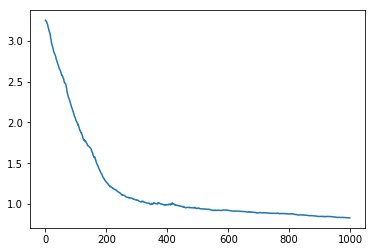

In [34]:
plt.figure()
plt.plot(hist * -1)

#### Probs have something to do with the depth / width, at least we know it works

In [44]:
scorenn.score(smol_batch_pixels,smol_batch_label)

84.375

Testing on a deeper and wider model.

According to the paper, wider is better, even at constant parameter count.

For starters, lets keep the 3 layers model, and make the hidden layers 1.25 times larger

In [45]:
newoptimizer = MomentumSGD(0.1,0.9)
newscorenn = ScoreFCNN([784,250,250,10],0.5,kaiming_uniform,kaiming_uniform,relu,crossentropy_with_logits,newoptimizer)

In [47]:
history = newscorenn.fit(train_pix,train_lab,32,30)

Epoch 0 done. Loss : -1.8331108940615084
Epoch 1 done. Loss : -1.522944064921419
Epoch 2 done. Loss : -1.412645136035685
Epoch 3 done. Loss : -1.3611039349474965
Epoch 4 done. Loss : -1.3249250791780547
Epoch 5 done. Loss : -1.2991338897112967
Epoch 6 done. Loss : -1.2748499986123325
Epoch 7 done. Loss : -1.2589125527808753
Epoch 8 done. Loss : -1.253383400435268
Epoch 9 done. Loss : -1.2469048133296965
Epoch 10 done. Loss : -1.2437076693705935
Epoch 11 done. Loss : -1.2413885529431736
Epoch 12 done. Loss : -1.2392799914328285
Epoch 13 done. Loss : -1.2371820350108493
Epoch 14 done. Loss : -1.2360652533747647
Epoch 15 done. Loss : -1.236215380809647
Epoch 16 done. Loss : -1.229829951376738
Epoch 17 done. Loss : -1.2201663124180477
Epoch 18 done. Loss : -1.210359149008943


KeyboardInterrupt: 

In [49]:
newscorenn.score(train_pix,train_lab)

82.45238095238095

In [48]:
newscorenn.score(test_pix,test_lab)

82.5952380952381